In [ ]:
!pip install sincnet-tensorflow

  Preparing metadata (setup.py) ... done
  Created wheel for sincnet-tensorflow: filename=sincnet_tensorflow-0.0.2-py3-none-any.whl size=5404 sha256=d762900cb6fd2101666c18b8aa4a03f8d2187a8f2ca16d836d61a20ada722cc2
  Stored in directory: /root/.cache/pip/wheels/5b/33/d4/e06720531a144468feaef52783cc61e732bba7405780623fb3
Successfully built sincnet-tensorflow


In [ ]:
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.layers import Dense, Conv1D, LeakyReLU, BatchNormalization, Flatten, MaxPooling1D, Input
from sincnet_tensorflow import SincConv1D, LayerNorm
import librosa
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def create_sincnet_model():
    inputs = Input((32000, 1))
    sinc_layer = SincConv1D(N_filt=64, Filt_dim=129, fs=16000, stride=16, padding="SAME")(inputs)
    x = LayerNorm()(sinc_layer)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(64, 3, strides=1, padding='valid')(x)
    x = BatchNormalization(momentum=0.05)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(64, 3, strides=1, padding='valid')(x)
    x = BatchNormalization(momentum=0.05)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(128, 3, strides=1, padding='valid')(x)
    x = BatchNormalization(momentum=0.05)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(128, 3, strides=1, padding='valid')(x)
    x = BatchNormalization(momentum=0.05)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Flatten()(x)

    x = Dense(256)(x)
    x = BatchNormalization(momentum=0.05, epsilon=1e-5)(x)
    x = LeakyReLU(alpha=0.2)(x)
    prediction = Dense(1, activation='sigmoid')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=prediction)
    return model


def load_audio_file(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    if len(y) < 32000:
        y = np.pad(y, (0, 32000 - len(y)), mode='constant')
    else:
        y = y[:32000]
    return y / np.max(np.abs(y))

real_audio_dir = '/content/drive/MyDrive/Real audio'
fake_audio_dir = '/content/drive/MyDrive/Fake audio'

real_audio_paths = [os.path.join(real_audio_dir, filename) for filename in os.listdir(real_audio_dir) if filename.endswith('.wav')]
fake_audio_paths = [os.path.join(fake_audio_dir, filename) for filename in os.listdir(fake_audio_dir) if filename.endswith('.wav')]

X = np.concatenate([load_audio_file(path) for path in real_audio_paths + fake_audio_paths])
X = X.reshape(-1, 32000, 1)
y = np.array([1] * len(real_audio_paths) + [0] * len(fake_audio_paths))

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

train_ds = tf.data.Dataset.from_tensor_slices((train_X, train_y))
train_ds = train_ds.shuffle(buffer_size=1024).batch(32)


model = create_sincnet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_ds, epochs=20, validation_data=(test_X, test_y))
model.save("my_model.h5")

test_loss, test_acc = model.evaluate(test_X, test_y)
print('Test accuracy:', test_acc)

Epoch 1/20
1/1 [==============================] - 5s 5s/step - loss: 0.5737 - accuracy: 0.7143 - val_loss: 2.2498 - val_accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 276ms/step - loss: 2.5023 - accuracy: 0.5000 - val_loss: 1.2556 - val_accuracy: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 276ms/step - loss: 1.2534 - accuracy: 0.6429 - val_loss: 1.1843 - val_accuracy: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 0s 268ms/step - loss: 0.6001 - accuracy: 0.7143 - val_loss: 0.7842 - val_accuracy: 0.2500
Epoch 5/20
1/1 [==============================] - 0s 240ms/step - loss: 0.3272 - accuracy: 0.9286 - val_loss: 0.5696 - val_accuracy: 0.7500
Epoch 6/20
1/1 [==============================] - 0s 294ms/step - loss: 0.2515 - accuracy: 0.9286 - val_loss: 0.4590 - val_accuracy: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 256ms/step - loss: 0.2191 - accuracy: 0.9286 - val_loss: 0.4166 - val_accuracy: 1.0000
Epoch 8/20


In [ ]:
from sincnet_tensorflow import SincConv1D
import keras.utils
from sincnet_tensorflow import LayerNorm

with keras.utils.custom_object_scope({'SincConv1D': SincConv1D, 'LayerNorm': LayerNorm}):
    model = tf.keras.models.load_model('/content/my_model.h5')
new_audio_file = '/content/fiza_cloned.wav'
new_audio_data = load_audio_file(new_audio_file)
new_audio_data = new_audio_data.reshape(1, 32000, 1)
prediction = model.predict(new_audio_data)

if prediction[0] > 0.5:
    print("Predicted as real audio")
else:
    print("Predicted as fake audio")

1/1 [==============================] - 1s 708ms/step
Predicted as fake audio


Epoch 1/20
1/1 [==============================] - 0s 328ms/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 0.1421 - val_accuracy: 1.0000
Epoch 2/20
1/1 [==============================] - 0s 272ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.1412 - val_accuracy: 1.0000
Epoch 3/20
1/1 [==============================] - 0s 267ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.1404 - val_accuracy: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 259ms/step - loss: 0.0100 - accuracy: 1.0000 - val_loss: 0.1395 - val_accuracy: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 254ms/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.1388 - val_accuracy: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 274ms/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 0.1380 - val_accuracy: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 360ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.1372 - val_accuracy: 1.0000
Epoch 8/20
1/1 [====

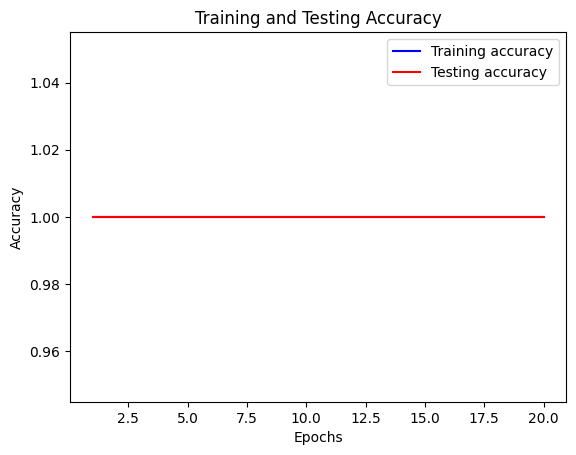

In [ ]:
history = model.fit(train_ds, epochs=20, validation_data=(test_X, test_y))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b-', label='Training accuracy')
plt.plot(epochs, val_acc, 'r-', label='Testing accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()  # Display the graph
